# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


# Parameters

In [729]:
m=1
p = 0.2
q = 0.9#0.01#0.5 #Pure SF is q=0
run = 1

1

Choose your grid

In [773]:
global compactified=true
global loggrid=false
global bisection=false
global zeroformat=false
global twod=true

true

In [774]:
using Quadmath, Printf

res=m;
N=2.0^m*1000.0/2.0

if compactified==true
    Xf=1.0
else
    Xf=20.0
end

dx=Xf/N
if loggrid==false
    dt=0.5*round(dx,digits=10)
else
    dt=0.1*round(dx,digits=10)
end
Nt=2.0^m*1000.0/2.0
Tf=Nt*dt;

In [775]:
print(N)

1000.0

In [776]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA"

# Grid

In [815]:
using Printf
include("./YangMills.jl");

In [828]:
ori=0.01#Float128(0.0)#0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

if loggrid==true
    global originalX=initX
    xtilde=gridfunc(initX1)
    initX1=xtilde
    initX=collect(initX)
    initX[4:L-3]=xtilde
end;

step size is  0.001
the time step is 0.00024364338119667198


# Initial data of m β Ψ and Ψ,x

In [829]:
using Dierckx


####

initm=zeros(L)
initbeta=zeros(L)
initpsi=zeros(L)
initxchi=zeros(L)
initderxchiu=zeros(L)
initderpsi=zeros(L)
initderxchi=zeros(L)


#state array is m beta psi xchi xchi,u psi,r xchi,r r
state_array=[initm initbeta initpsi initxchi initderxchiu initderpsi initderxchi initX];

#PSI,R
A=0.075*p*(1−q)
r0=0.75
sigma=0.25

initderpsi[4:L-3] = init_derpsi(initX1,r0,sigma,A)

state_array[:,6] = initderpsi
state_array=ghost(state_array)

#RCHI,R
A=0.25*p*q
r0=0.3
sigma=0.1

initderxchi[4:L-3] = init_derxchi(initX1,r0,sigma,A)

state_array[:,7] = initderxchi

####
#PSI FROM PSI,R, CHI FROM CHI,R
derpsi_func = Spline1D(initX[4:L-3], state_array[4:L-3,6],  k=4);
derxchi_func = Spline1D(initX[4:L-3], state_array[4:L-3,7],  k=4);

funcs=[derpsi_func derxchi_func];

In [830]:
y0=[0.0 0.0 0.0 0.0 0.0]

state_array[4:L-3,1:5] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,funcs,state_array[:,:]);

#state_array = ghost(state_array);

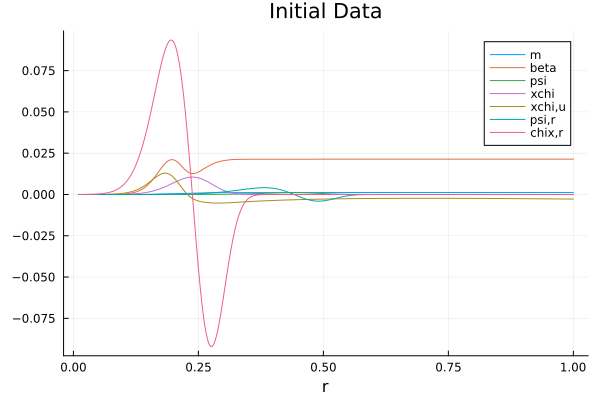

In [831]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:7], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "xchi" "xchi,u" "psi,r" "chix,r"])#,ylim=[-0.1,0.1])

In [832]:
state_array

997×8 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0         0.007
 0.0          0.0          0.0             0.0          0.0         0.008
 0.0          0.0          0.0             0.0          0.0         0.009
 0.0          0.0          0.0             2.91838e-7   1.57194e-5  0.01
 9.62802e-16  2.40097e-9   3.04609e-10     3.04724e-7   1.72513e-5  0.011
 2.17355e-15  5.51138e-9   6.23253e-10  …  3.18065e-7   1.89051e-5  0.012
 3.78594e-15  9.42565e-9   9.56465e-10     3.31876e-7   2.06894e-5  0.013
 5.99481e-15  1.42485e-8   1.30479e-9      3.46174e-7   2.26134e-5  0.014
 9.04884e-15  2.00958e-8   1.66881e-9      3.60974e-7   2.46866e-5  0.015
 1.32654e-14  2.7096e-8    2.0491e-9       3.76292e-7   2.69195e-5  0.016
 1.90485e-14  3.53907e-8   2.44627e-9   …  3.92144e-7   2.93229e-5  0.017
 2.69101e-14  4.51365e-8   2.86096e-9      4.08548e-7   3.19085e-5  0.018
 3.74967e-14  5.65061e-8   3.29382e-9      4.25522e-7   3.46886e-5  0.019
 ⋮              

In [833]:
function compactify(r)
    return r/(1+r)
end
function uncompactify(x)
    return x/(1-x)
end;

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [834]:
using CSV, Tables
#CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

global files=["m", "beta", "psi", "xchi", "deruxchi", "derpsi", "derxchi"]

print_muninn(files, 0, state_array[:,:],res,"w")

In [835]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
global monitor_ratio = zeros(L);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

In [836]:
ginit=speed(initX,state_array[:,1],state_array[:,2])
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

0.8341651340474339


In [837]:
using Base.Threads
Threads.nthreads()

4

In [838]:
if m==1
    global dt=2e-8
elseif m==2
    global dt=1e-6
else
    global dt=1e-6/2
end

2.0e-8

 ## Time evolution

fixed grid

In [839]:
finaltime=3.0
evol_stats, T_interp = timeevolution(state_array,finaltime,run);
#CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);



iteration 5 dt is 0.0002032388150458499, t=0.001016194073814693 speed is 0.4920319968281664, dx/dt=4.920319968281668


iteration 10 dt is 0.0002032388151370424, t=0.0020323881493151882 speed is 0.4920319966073935, dx/dt=4.920319966073939


iteration 15 dt is 0.00020323881523424126, t=0.003048582225289523 speed is 0.49203199637207945, dx/dt=4.920319963720798


iteration 20 dt is 0.00020323881533781054, t=0.004064776301768813 speed is 0.4920319961213429, dx/dt=4.920319961213433


iteration 25 dt is 0.0002032388154481346, t=0.005080970378786058 speed is 0.4920319958542534, dx/dt=4.920319958542538


iteration 30 dt is 0.00020323881556561917, t=0.006097164456376236 speed is 0.49203199556982846, dx/dt=4.920319955698289


iteration 35 dt is 0.0002032388156906921, t=0.007113358534576427 speed is 0.4920319952670325, dx/dt=4.920319952670329


iteration 40 dt is 0.00020323881582380481, t=0.008129552613425914 speed is 0.4920319949447727, dx/dt=4.920319949447731


iteration 45 dt is 0.00020323881



iteration 345 dt is 0.0002032388858919348, t=0.07011739728782844 speed is 0.4920318253130527, dx/dt=4.920318253130532


iteration 350 dt is 0.000203238889588079, t=0.0711335917283115 speed is 0.4920318163648609, dx/dt=4.920318163648613


iteration 355 dt is 0.00020323889344964742, t=0.0721497861877693 speed is 0.4920318070161851, dx/dt=4.920318070161855


iteration 360 dt is 0.0002032388974823407, t=0.07316598066704602 speed is 0.49203179725322443, dx/dt=4.920317972532248


iteration 365 dt is 0.00020323890169191805, t=0.07418217516701456 speed is 0.49203178706203615, dx/dt=4.920317870620366


iteration 370 dt is 0.00020323890608418317, t=0.07519836968857671 speed is 0.49203177642856993, dx/dt=4.920317764285703


iteration 375 dt is 0.0002032389106649686, t=0.0762145642326634 speed is 0.49203176533870524, dx/dt=4.920317653387057


iteration 380 dt is 0.0002032389154401184, t=0.07723075880023478 speed is 0.49203175377829433, dx/dt=4.920317537782947


iteration 385 dt is 0.000203238920



iteration 685 dt is 0.0002032391969094835, t=0.13921870226181707 speed is 0.49203107235528415, dx/dt=4.920310723552846


iteration 690 dt is 0.00020323915788625932, t=0.14023489813160347 speed is 0.4920311668284115, dx/dt=4.920311668284119


iteration 695 dt is 0.00020323911281426013, t=0.14125109378835154 speed is 0.492031275945343, dx/dt=4.920312759453434


iteration 700 dt is 0.00020323906110956857, t=0.14226728920008475 speed is 0.4920314011197323, dx/dt=4.920314011197327


iteration 705 dt is 0.00020323900213839466, t=0.1432834843317591 speed is 0.4920315438859781, dx/dt=4.9203154388597845


iteration 710 dt is 0.00020323893521276813, t=0.14429967914500083 speed is 0.49203170590965384, dx/dt=4.920317059096543


iteration 715 dt is 0.00020323885958581996, t=0.1453158735978216 speed is 0.49203188899893313, dx/dt=4.9203188899893355


iteration 720 dt is 0.00020323877444660605, t=0.14633206764430878 speed is 0.4920320951171227, dx/dt=4.920320951171231


iteration 725 dt is 0.0002032



iteration 1025 dt is 0.0002028978495081618, t=0.20830259515639168 speed is 0.49285884617509124, dx/dt=4.928588461750916


iteration 1030 dt is 0.00020286149114337153, t=0.2093169768402105 speed is 0.4929471800506747, dx/dt=4.929471800506751


iteration 1035 dt is 0.00020282114829049637, t=0.21033116494585344 speed is 0.49304523144091494, dx/dt=4.930452314409154


iteration 1040 dt is 0.00020277638091731424, t=0.2113451382488136 speed is 0.49315408208600364, dx/dt=4.93154082086004


iteration 1045 dt is 0.0002027267016785159, t=0.21235887318429358 speed is 0.49327493207372336, dx/dt=4.932749320737238


iteration 1050 dt is 0.00020267157120069446, t=0.2133723435966482 speed is 0.4934091121293743, dx/dt=4.934091121293747


iteration 1055 dt is 0.00020261039297568212, t=0.21438552046408405 speed is 0.4935580970518241, dx/dt=4.935580970518244


iteration 1060 dt is 0.00020254250784615356, t=0.21539837159660857 speed is 0.49372352037804096, dx/dt=4.937235203780414


iteration 1065 dt is 0.



iteration 1365 dt is 0.0001184002948264258, t=0.26963506274981847 speed is 0.8445924914849189, dx/dt=8.445924914849197


iteration 1370 dt is 0.00011589498169607333, t=0.2702195288751721 speed is 0.8628501298032307, dx/dt=8.628501298032313


iteration 1375 dt is 0.00011343957025693702, t=0.2707916170646146 speed is 0.8815266116885238, dx/dt=8.815266116885244


iteration 1380 dt is 0.00011103649657709892, t=0.2713515843349349 speed is 0.9006047838564887, dx/dt=9.006047838564895


iteration 1385 dt is 0.00010868771298872223, t=0.2718996984186128 speed is 0.9200672021719348, dx/dt=9.200672021719356


iteration 1390 dt is 0.00010639472308607275, t=0.27243623544908796 speed is 0.9398962382664454, dx/dt=9.398962382664463


iteration 1395 dt is 0.0001041586187143248, t=0.27296147782747987 speed is 0.9600741756596188, dx/dt=9.600741756596195


iteration 1400 dt is 0.00010198011782354324, t=0.2734757122772589 speed is 0.9805832953932302, dx/dt=9.80583295393231


iteration 1405 dt is 9.9859602



iteration 1710 dt is 4.2479659358837573e-5, t=0.29304916182528473 speed is 2.3540678411583276, dx/dt=23.540678411583297


iteration 1715 dt is 4.216144959125914e-5, t=0.29326060160030804 speed is 2.371834957513695, dx/dt=23.718349575136973


iteration 1720 dt is 4.185285723567796e-5, t=0.29347047926918335 speed is 2.3893231335889236, dx/dt=23.893231335889254


iteration 1725 dt is 4.155366132214711e-5, t=0.2936788422519486 speed is 2.4065268093885703, dx/dt=24.065268093885724


iteration 1730 dt is 4.126365097908706e-5, t=0.29388573689423186 speed is 2.423440428252003, dx/dt=24.23440428252005


iteration 1735 dt is 4.098262508057199e-5, t=0.29409120851667764 speed is 2.440058434602458, dx/dt=24.4005843460246


iteration 1740 dt is 4.071039191142684e-5, t=0.29429530146266364 speed is 2.4563752718855874, dx/dt=24.56375271885589


iteration 1745 dt is 4.04467688493709e-5, t=0.29449805914439425 speed is 2.472385380706506, dx/dt=24.72385380706508


iteration 1750 dt is 4.019158206345524e-

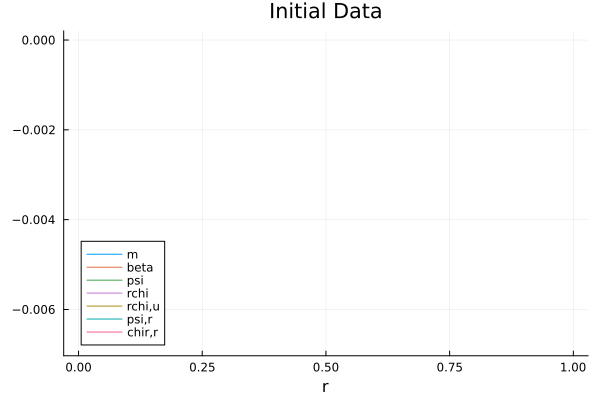

In [625]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:7], xaxis="r",title="Initial Data", labels=["m" "beta" "psi" "rchi" "rchi,u" "psi,r" "chir,r"])#,ylim=[-0.1,0.1])

In [566]:
state_array[:,4:5]

407×2 Matrix{Float64}:
 NaN      0.0
 NaN      0.0
 NaN      0.0
   0.0    0.0
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
   ⋮    
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN    NaN
 NaN      0.0
 NaN      0.0
 NaN      0.0

#### 

 ## Movie of the evolution, apparent horizon formation for 0.0492<A*<0.04925

In [336]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 710:710
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    temp=round(n*dt,digits=2)
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], title="$temp", ylim=[-0.01, 0.01],xlim=[0.0, 0.1])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/YangMills/DATA/res1/time_step710.csv" is not a valid file or doesn't exist

In [49]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8000:100:10000
    
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot6=functions3.Column1[4:L-3] .* 2 .* (1 .- functions3.Column5[4:L-3]) ./functions3.Column5[4:L-3];
    
    
    plot!(initX1, plot6, labels=["monitor ratio"], ylim=[-1.3, 0.6],xlim=[0.0, 0.3])#, xlim=[0, 0.1])# |> display 
    
    end

gif(anim, "N2000_A$A.gif", fps = 15000)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step8000.csv" is not a valid file or doesn't exist

In [50]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

In [141]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 8200:5:8430
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1],xlim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1500)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/monitor_ratio8200.csv" is not a valid file or doesn't exist

Sanity check for der func

In [207]:
array=init_gaussian(originalX,0.7,0.3,0.01)
arrayloggrid=init_gaussian(initX,0.7,0.3,0.01);

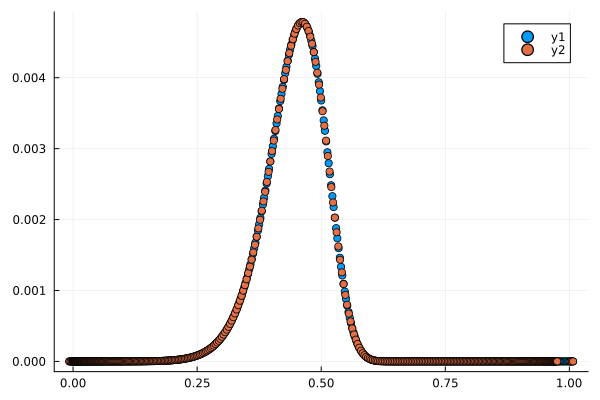

In [209]:
scatter([originalX, initX], [array, arrayloggrid])

In [210]:
aux=zeros(L)

loggrid=false
for i in 4:L-3
    aux[i]=Dertest(array,i,originalX)
end
x1=originalX
y1=aux


loggrid=true
for i in 4:L-3
    aux[i]=Dertest(arrayloggrid,i,initX)
end
x2=initX
y2=aux;

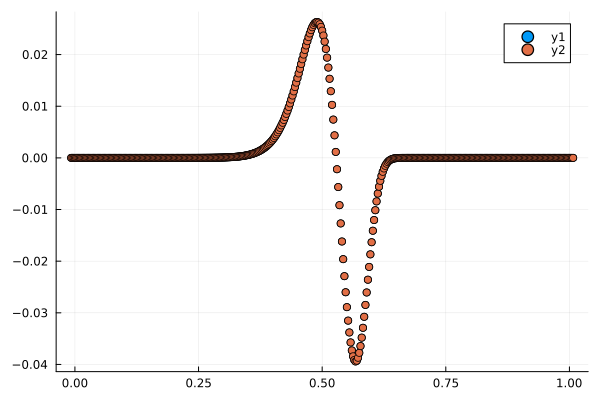

In [417]:
scatter([x1,x1],[y1,y2])